In [1]:
! git clone https://github.com/davidguzmanr/Practical-Black-Box-Attacks-against-Machine-Learning.git
! pip install -r Practical-Black-Box-Attacks-against-Machine-Learning/requirements.txt --quiet

Cloning into 'Practical-Black-Box-Attacks-against-Machine-Learning'...
remote: Enumerating objects: 565, done.
remote: Counting objects: 100% (2/2), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 565 (delta 0), reused 1 (delta 0), pack-reused 563
Receiving objects: 100% (565/565), 50.85 MiB | 25.15 MiB/s, done.
Resolving deltas: 100% (324/324), done.
     |████████████████████████████████| 1.7 MB 7.9 MB/s 
     |████████████████████████████████| 158 kB 61.2 MB/s 
     |████████████████████████████████| 708 kB 50.1 MB/s 
     |████████████████████████████████| 62 kB 417 kB/s 
     |████████████████████████████████| 182 kB 46.4 MB/s 
     |████████████████████████████████| 529 kB 57.7 MB/s 
     |████████████████████████████████| 63 kB 1.9 MB/s 


In [2]:
%cd Practical-Black-Box-Attacks-against-Machine-Learning/

/content/Practical-Black-Box-Attacks-against-Machine-Learning


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix
from tqdm.notebook import tqdm, trange

import torch
import torchinfo

from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import save_image

from foolbox import PyTorchModel, accuracy, samples
from foolbox.attacks import FGSM, LinfPGD

from src.black_box.model import BlackBoxModel
from src.black_box.oracle import get_oracle_prediction
from src.substitute.datasets import SubstituteDataset, INDICES
from src.substitute.model import SubstituteModel

torch.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Substitute training

![Substitute training](https://raw.githubusercontent.com/davidguzmanr/Practical-Black-Box-Attacks-against-Machine-Learning/main/images/training_substitute_dnn.png)

1. **Substitute training dataset collection:** 150 images of MNIST test set (15 per digit) as $S_{0}$.
2. **Substitute DNN architecture selection:** a simple network as described on the appendix of [Practical Black-Box Attacks against Machine Learning](https://arxiv.org/abs/1602.02697).
3. **Substitute dataset labeling:** for each sample in the substitute we get its label with the oracle $O(\pmb{x}) = y$.
4. **Substitute model training:** train the substitute model with the current substitute dataset $S_{p}$.
5. **Jacobian-based dataset augmentation:** produce a larger substitute train-
ing set $S_{p+1}$ with more synthetic training points.


In [2]:
p_epochs = 6    # Number of substitute epochs
epochs = 10     # Number of epochs to train the model at each substitute epoch
lr = 1e-2       # Learning rate
lambda_ = 0.1   # Parameter for Jacobian-based dataset augmentation

In [3]:
substitute_model = SubstituteModel()
substitute_model.to(device)
torchinfo.summary(substitute_model)

Layer (type:depth-idx)                   Param #
SubstituteModel                          --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       160
│    └─ReLU: 2-2                         --
│    └─MaxPool2d: 2-3                    --
│    └─Conv2d: 2-4                       8,256
│    └─ReLU: 2-5                         --
│    └─MaxPool2d: 2-6                    --
├─Sequential: 1-2                        --
│    └─Linear: 2-7                       1,179,680
│    └─ReLU: 2-8                         --
│    └─Linear: 2-9                       330
Total params: 1,188,426
Trainable params: 1,188,426
Non-trainable params: 0

In [ ]:
# STEP 1: Initial Collection
substitute_dataset = SubstituteDataset(
    root_dir='src/substitute/data/training_set_0', # 150 MNIST images here
    get_predictions=get_oracle_prediction,
    transform=None
)

# STEP 2: Architecture Selection, a simple NN
substitute_model = SubstituteModel()
substitute_model.to(device)

for p in trange(p_epochs + 1, desc='Substitute training'):
    # STEP 3: Labeling with oracle, we use get_oracle_prediction to do that,
    # which we treat as a black box in which we only can see the outputs
    substitute_dataset = SubstituteDataset(
        root_dir=f'src/substitute/data/training_set_{p}',
        get_predictions=get_oracle_prediction,
        transform=None
    )
    train_dataloader = DataLoader(
        substitute_dataset, 
        batch_size=8, 
        shuffle=True
    )

    # STEP 4: Training the substitute model
    substitute_model.train_model(train_dataloader, epochs=epochs, lr=lr)

    # STEP 5: Jacobian dataset augmentation
    substitute_model.jacobian_dataset_augmentation(
        substitute_dataset=substitute_dataset,
        p=(p + 1),
        lambda_=lambda_,
        root_dir=f'src/substitute/data/training_set_{p+1}',
    )
    
    # Let's save the model at each substitute epoch p
    torch.save(substitute_model.state_dict(), f'models/substitute_model_p_{p}.pt')

# Final substitute model
torch.save(substitute_model.state_dict(), f'models/substitute_model.pt')

In [34]:
for p in trange(p_epochs, desc='Substitute training'):
    substitute_dataset = SubstituteDataset(
        root_dir=f'src/substitute/data/training_set_{p}',
        get_predictions=get_oracle_prediction,
        transform=None
    )
    
    # We have to remove the test images we took to create the initial dataset S0
    acc = []
    labels = [i // 15 for i in range(150)] * (len(substitute_dataset) // 150)
    for i in trange(len(substitute_dataset), desc=f'Accurary oracle p={p}', leave=False):
        image, _ = substitute_dataset.__getitem__(i)
        label = labels[i]
        image = image.unsqueeze(dim=0).to(device)
        prediction = get_oracle_prediction(image)
        acc.append(prediction.item() == label)
        
    print(f'Accuracy p={p}: {100 * np.mean(acc):0.3f}')

Substitute training:   0%|          | 0/6 [00:00<?, ?it/s]

Accurary oracle p=0:   0%|          | 0/150 [00:00<?, ?it/s]

Accuracy p=0: 99.333


Accurary oracle p=1:   0%|          | 0/300 [00:00<?, ?it/s]

Accuracy p=1: 99.333


Accurary oracle p=2:   0%|          | 0/600 [00:00<?, ?it/s]

Accuracy p=2: 98.167


Accurary oracle p=3:   0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy p=3: 98.333


Accurary oracle p=4:   0%|          | 0/2400 [00:00<?, ?it/s]

Accuracy p=4: 98.000


Accurary oracle p=5:   0%|          | 0/4800 [00:00<?, ?it/s]

Accuracy p=5: 97.750


In [48]:
dataset = SubstituteDataset(
    root_dir='src/substitute/data/training_set_0', # 150 MNIST images here
    get_predictions=get_oracle_prediction,
    transform=None
)
loader = DataLoader(
    dataset,
    batch_size=8,
    num_workers=1,
    shuffle=False
)


mean = 0.
std = 0.
for images, _ in loader:
    batch_samples = images.size(0) # batch size (the last batch can have smaller size!)
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)

mean /= len(loader.dataset)
std /= len(loader.dataset)

print(f'Mean {mean}')
print(f'Std {std}')a

Mean tensor([0.1263])
Std tensor([0.2966])


In [50]:
for p in trange(p_epochs + 1):
    dataset = SubstituteDataset(
        root_dir=f'src/substitute/data/training_set_{p}', # 150 MNIST images here
        get_predictions=get_oracle_prediction,
        transform=None
    )
    loader = DataLoader(
        dataset,
        batch_size=8,
        num_workers=1,
        shuffle=False
    )


    mean = 0.
    std = 0.
    for images, _ in loader:
        batch_samples = images.size(0) # batch size (the last batch can have smaller size!)
        images = images.view(batch_samples, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)

    mean /= len(loader.dataset)
    std /= len(loader.dataset)

    print(f'Mean p={p}: {mean}')
    print(f'Std p={p}: {std}\n')

  0%|          | 0/7 [00:00<?, ?it/s]

Mean p=0: tensor([0.1263])
Std p=0: tensor([0.2966])

Mean p=1: tensor([0.1266])
Std p=1: tensor([0.3075])

Mean p=2: tensor([0.1264])
Std p=2: tensor([0.3193])

Mean p=3: tensor([0.1271])
Std p=3: tensor([0.3300])

Mean p=4: tensor([0.1272])
Std p=4: tensor([0.3411])

Mean p=5: tensor([0.1275])
Std p=5: tensor([0.3528])

Mean p=6: tensor([0.1292])
Std p=6: tensor([0.3625])



Now lets see how the model perform at each substitute epoch $p$.

In [7]:
transform = transforms.ToTensor()

mnist_test = MNIST(
    root='src/black_box/data', 
    train=False, 
    download=True, 
    transform=transform
)

for p in trange(p_epochs + 1):
    substitute_model = SubstituteModel()
    substitute_model.load_state_dict(torch.load(f'models/substitute_model_p_{p}.pt'))
    substitute_model = substitute_model.to(device)
    substitute_model.eval()

    # We have to remove the test images we took to create the initial dataset S0
    test_indices = [i for i in range(len(mnist_test)) if i not in INDICES]
    acc = []
    for i in tqdm(test_indices, desc=f'Accurary p={p}', leave=False):
        image, label = mnist_test.__getitem__(i)
        image = image.unsqueeze(dim=0).to(device)
        prediction = substitute_model(image).argmax(dim=-1)
        acc.append(prediction.item() == label)

    print(f'Accuracy p={p} {100*np.mean(acc):0.2f}')

  0%|          | 0/7 [00:00<?, ?it/s]

Accurary p=0:   0%|          | 0/9850 [00:00<?, ?it/s]

Accuracy p=0 78.39


Accurary p=1:   0%|          | 0/9850 [00:00<?, ?it/s]

Accuracy p=1 77.80


Accurary p=2:   0%|          | 0/9850 [00:00<?, ?it/s]

Accuracy p=2 79.57


Accurary p=3:   0%|          | 0/9850 [00:00<?, ?it/s]

Accuracy p=3 80.10


Accurary p=4:   0%|          | 0/9850 [00:00<?, ?it/s]

Accuracy p=4 79.12


Accurary p=5:   0%|          | 0/9850 [00:00<?, ?it/s]

Accuracy p=5 83.01


Accurary p=6:   0%|          | 0/9850 [00:00<?, ?it/s]

Accuracy p=6 78.54


# Attacks against the oracle
We will use the substitute model to create adversarial samples for the oracle and see how well they perform.

In [38]:
substitute_model = SubstituteModel()
substitute_model.load_state_dict(torch.load('models/substitute_model.pt', map_location=device))
substitute_model.eval()

transform = transforms.ToTensor()

mnist_test = MNIST(
    root='src/black_box/data', 
    train=False, 
    download=True, 
    transform=transform
)

test_indices = [i for i in range(len(mnist_test)) if i not in INDICES]
images = torch.stack([mnist_test.__getitem__(i)[0] for i in test_indices])
labels = torch.tensor([mnist_test.__getitem__(i)[1] for i in test_indices])
images, labels = images.to(device), labels.to(device)

# preprocessing = dict(mean=[0.1307], std=[0.3081], axis=-3)
fmodel = PyTorchModel(substitute_model, bounds=(0, 1), preprocessing=None)

attack = FGSM()
epsilons = [0.00, 0.05, 0.20, 0.25, 0.30]

raw_advs, clipped_advs, success = attack(fmodel, images, labels, epsilons=epsilons)

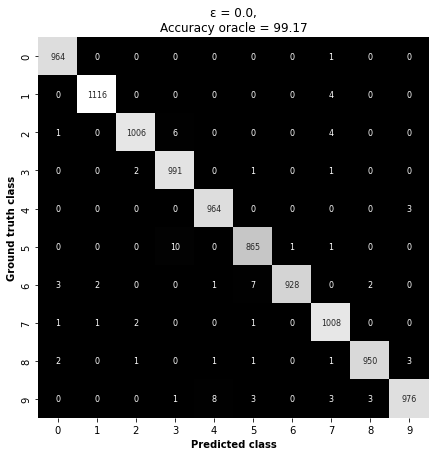

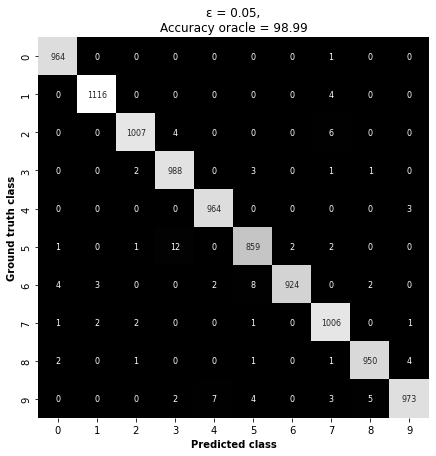

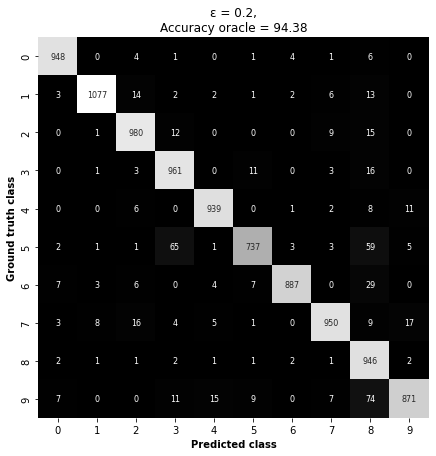

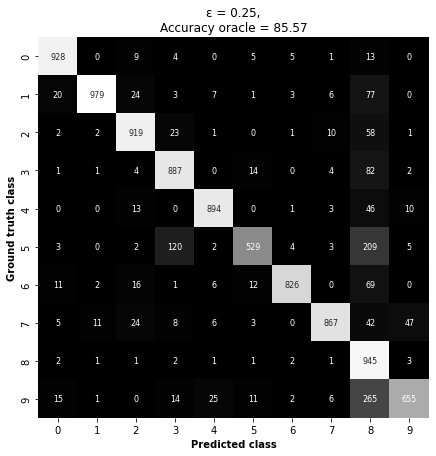

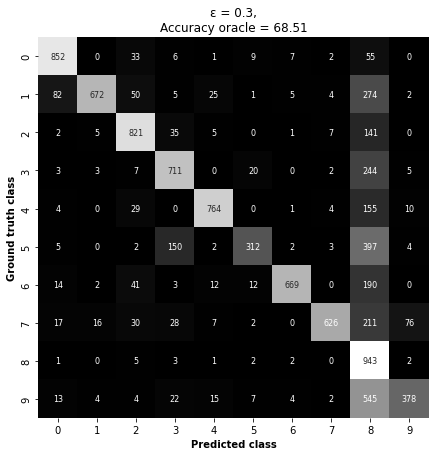

In [10]:
for (i, epsilon) in enumerate(epsilons):
    y_true, y_pred_oracle = [], []
    for (label, image_adversarial) in zip(labels, raw_advs[i]):
        label, image_adversarial = label.to(device), image_adversarial.to(device)

        prediction_oracle = get_oracle_prediction(image_adversarial.unsqueeze(dim=0))
        
        y_true.append(label.item())
        y_pred_oracle.append(prediction_oracle.item())
        
    accuracy_oracle = 100 * accuracy_score(y_true, y_pred_oracle)
    
    df_cm = pd.DataFrame(confusion_matrix(y_true, y_pred_oracle), range(10), range(10))
    plt.figure(figsize=(7,7))
    sns.heatmap(df_cm, annot=True, annot_kws={"size": 8}, cbar=False, cmap='gray', fmt='0.0f') 
    
    plt.xlabel('Predicted class', fontweight='bold')
    plt.ylabel('Ground truth class', fontweight='bold')
    plt.title(f'ε = {epsilon},\nAccuracy oracle = {accuracy_oracle:.2f}')
    
    plt.show()

And let's how the actual adversarial samples look.

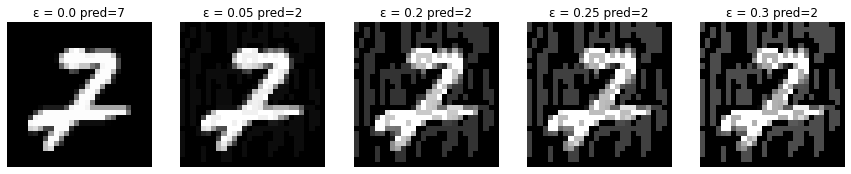

In [36]:
j = 8859

fig, ax = plt.subplots(figsize=(15,10), nrows=1, ncols=5)

for (i, epsilon) in enumerate(epsilons):
    image = raw_advs[i][j]
    prediction = get_oracle_prediction(image.unsqueeze(dim=0))
  
    ax[i].imshow(image.cpu().squeeze(), cmap='gray')
    ax[i].set_title(f'ε = {epsilon} pred={prediction.item()}')
    ax[i].axis('off')

plt.show()